# Airbnb Occupancy Analysis

In [1]:
# Importing standard libraries

import numpy as np #for numerical calculations
import pandas as pd #for working on dataframes

from datetime import datetime

np.random.seed(42) #for generating same set of random numbers in multiple runs

import matplotlib.pyplot as plt # for plotting
import seaborn as sns #for nicer looking plots

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### From the previous analysis for review score, we cleaned up the data. We are using the cleaned data in this notebook to further analyze occupancy.

In [2]:
listing_clean = pd.read_csv('Listing_clean.csv')

In [3]:
listing_clean.iloc[:,43:60].head()

,neighborhood_overview,amenities,is_location_exact,review_scores_value,instant_bookable,house_rules,calendar_updated,property_type,weekly_price,latitude,cleaning_fee,last_review,summary,beds,host_total_listings_count,feature_review_score
0,225.0,361,1,10.0,1,110.0,1,Apartment,1120.0,37.76931,100.0,17 days 00:00:00.000000000,406.0,2.0,1,17460.0
1,320.0,211,1,9.0,0,67.0,0,Apartment,1600.0,37.74511,100.0,577 days 00:00:00.000000000,0.0,3.0,2,10878.0
2,69.0,303,1,8.0,0,88.0,0,Apartment,485.0,37.76669,50.0,835 days 00:00:00.000000000,249.0,1.0,10,1445.0
3,0.0,227,1,9.0,0,44.0,0,Apartment,490.0,37.76487,50.0,175 days 00:00:00.000000000,249.0,1.0,10,744.0
4,0.0,150,1,9.0,0,303.0,0,House,0.0,37.77525,225.0,207 days 00:00:00.000000000,243.0,2.0,2,2619.0


In [4]:
listings = listing_clean[['host_about', 'access', 'accommodates', 'space', 'require_guest_phone_verification',
                         'minimum_nights', 'review_scores_rating', 'host_name', 'name', 'room_type', 'requires_license',
                         'host_response_time', 'number_of_reviews', 'bedrooms', 'guests_included', 'host_since',
                         'bed_type', 'transit', 'price', 'security_deposit', 'host_location', 'host_has_profile_pic',
                         'host_response_rate', 'host_identity_verified', 'description', 'bathrooms', 'extra_people',
                         'neighbourhood_cleansed', 'reviews_per_month', 'host_is_superhost','cancellation_policy', 
                         'monthly_price','longitude', 'neighborhood_overview','amenities','instant_bookable', 
                          'calendar_updated','property_type', 'latitude','cleaning_fee','summary', 'feature_review_score']]

### There is no information on occupancy in the dataset. But we can use the minimum number of nights and the number of reviews per month  to calculate the occupancy rate per month 

In [5]:
listings['occupancy_rate_month'] = round(listings.reviews_per_month * listings.minimum_nights/30,2)

In [6]:
listings['occupancy_rate_month'][listings.occupancy_rate_month>1]=np.nan
listings_occupancy = listings.dropna().reset_index(drop=True)

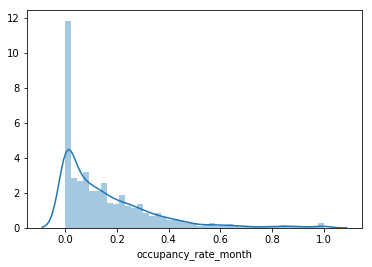

In [7]:
sns.distplot(listings_occupancy['occupancy_rate_month'])

## Exploratory Data Analysis

In [8]:
listings_occupancy = listings_occupancy.drop(['review_scores_rating', 'number_of_reviews', 'reviews_per_month'], axis=1)

In [9]:
listings_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 40 columns):
host_about                          6682 non-null float64
access                              6682 non-null float64
accommodates                        6682 non-null int64
space                               6682 non-null float64
require_guest_phone_verification    6682 non-null int64
minimum_nights                      6682 non-null int64
host_name                           6682 non-null object
name                                6682 non-null int64
room_type                           6682 non-null object
requires_license                    6682 non-null int64
host_response_time                  6682 non-null object
bedrooms                            6682 non-null float64
guests_included                     6682 non-null int64
host_since                          6682 non-null int64
bed_type                            6682 non-null object
transit                             6682 

Text(0, 0.5, 'Count')

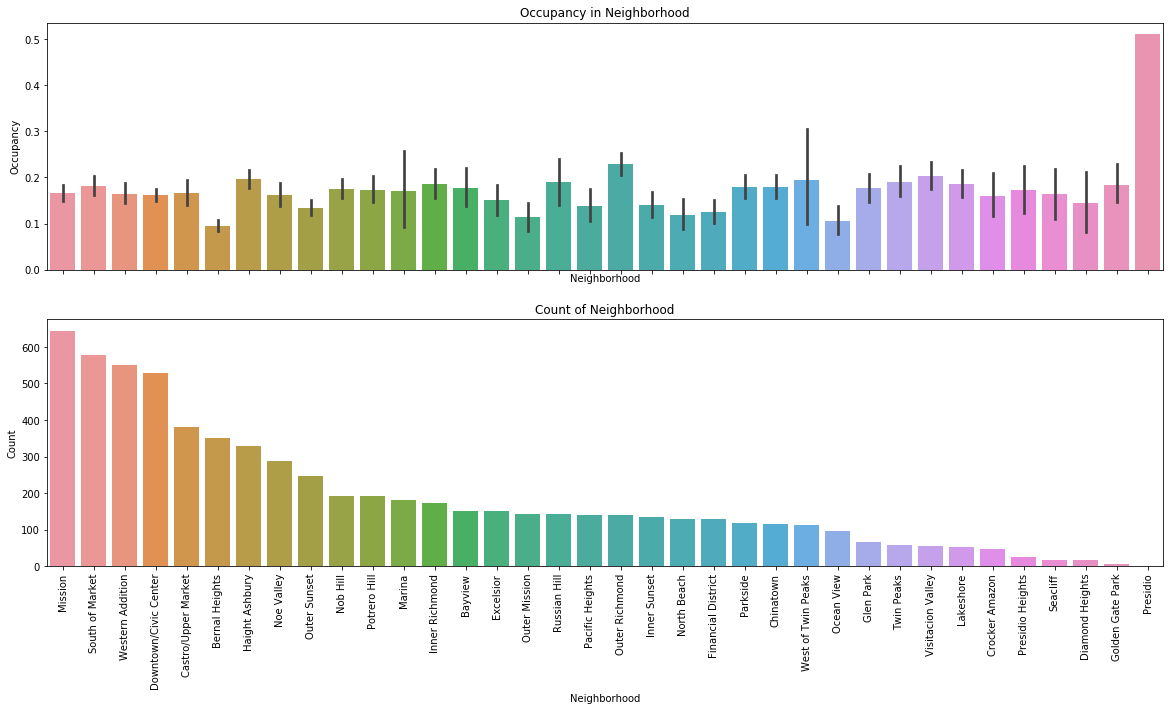

In [10]:
# Occupancy plot by neigborhood
count, ax = plt.subplots(2,1, figsize = (20,10), sharex=True)
ax = sns.barplot(x="neighbourhood_cleansed", y="occupancy_rate_month",data=listings_occupancy, ax=ax[0])
ax.set_title('Occupancy in Neighborhood')
plt.xticks(rotation=90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Occupancy')

ax = sns.countplot('neighbourhood_cleansed', data=listings_occupancy, 
                   order=listings_occupancy['neighbourhood_cleansed'].value_counts().index)
ax.set_title('Count of Neighborhood')
plt.xticks(rotation=90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Count')

#### Mission and South of Market has the most number of listings- their occupancy is more or less same 17-19%.  Even though Presidio seems to have a much higher occupancy rate, there is only one property listed in that neighborhood. 

In [11]:
listings_occupancy.groupby('neighbourhood_cleansed')['occupancy_rate_month'].mean().sort_values(ascending=False)

neighbourhood_cleansed
Presidio                 0.510000
Outer Sunset             0.228049
Outer Mission            0.203958
Castro/Upper Market      0.195763
Seacliff                 0.194444
Twin Peaks               0.190702
Bayview                  0.189868
Parkside                 0.186271
Nob Hill                 0.185654
Visitacion Valley        0.182593
Bernal Heights           0.181795
Inner Richmond           0.179477
Excelsior                0.178800
Ocean View               0.177629
West of Twin Peaks       0.177018
Noe Valley               0.175848
Outer Richmond           0.173357
Crocker Amazon           0.171875
Presidio Heights         0.170000
Western Addition         0.166134
Potrero Hill             0.165654
Haight Ashbury           0.164742
Golden Gate Park         0.164000
Inner Sunset             0.161926
Mission                  0.161677
Lakeshore                0.159623
Pacific Heights          0.150000
Diamond Heights          0.145000
North Beach              

#### From the table above, Outer sunset and Outer mission have higher occupancy rates.

Text(0, 0.5, 'Count')

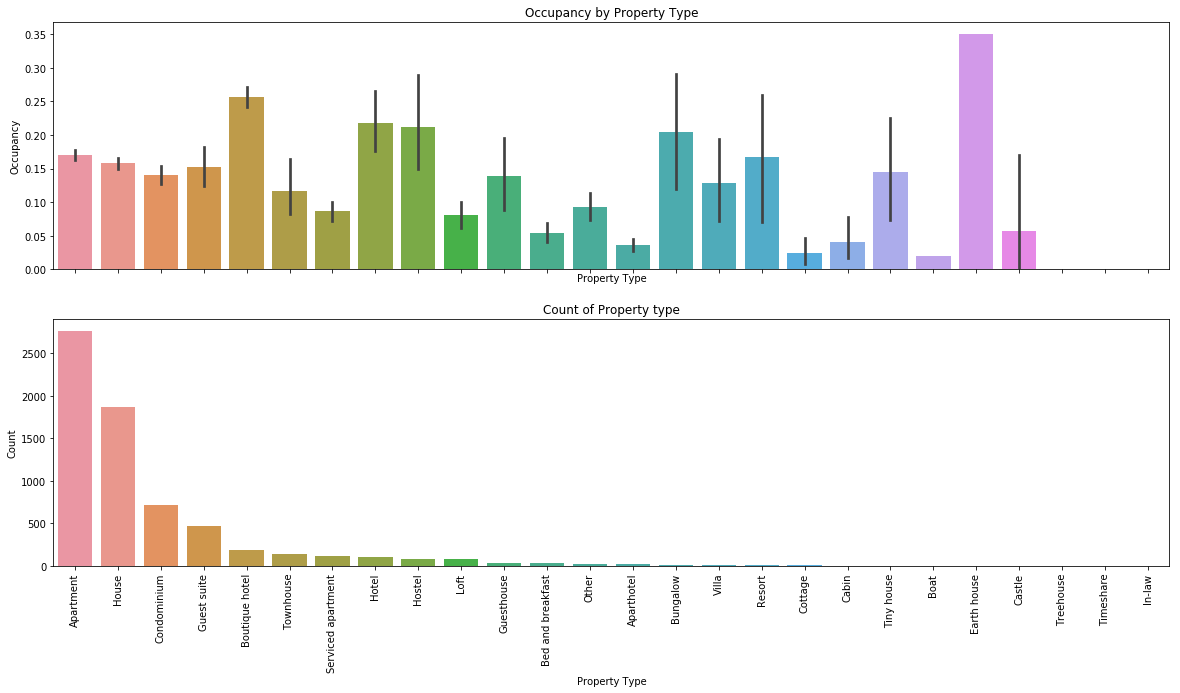

In [12]:
# Occupancy plot by property type
count, ax = plt.subplots(2,1,figsize = (20,10), sharex=True)
ax = sns.barplot(x="property_type", y="occupancy_rate_month",data=listings_occupancy, ax=ax[0])
ax.set_title('Occupancy by Property Type')
plt.xticks(rotation=90)
ax.set_xlabel('Property Type')
ax.set_ylabel('Occupancy')

ax = sns.countplot('property_type', data=listings_occupancy,
                   order=listings_occupancy['property_type'].value_counts().index)
ax.set_title('Count of Property type')
plt.xticks(rotation=90)
ax.set_xlabel('Property Type')
ax.set_ylabel('Count')

#### We can see that, Apartments and Houses are the majority properties and both of them have occupancy of 15-17%. 

Text(0, 0.5, 'Count')

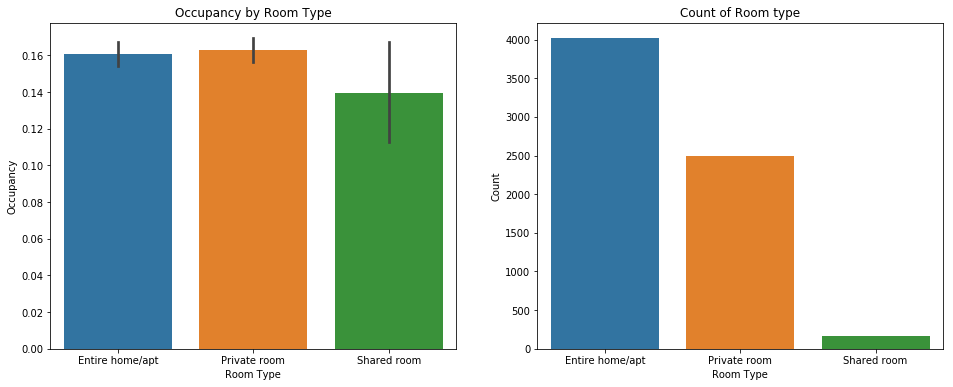

In [13]:
# Occupancy plot by room_type
count, ax = plt.subplots(1,2, figsize = (16,6))
ax = sns.barplot(x="room_type", y="occupancy_rate_month",data=listings_occupancy, ax=ax[0])
ax.set_title('Occupancy by Room Type')
ax.set_xlabel('Room Type')
ax.set_ylabel('Occupancy')

ax = sns.countplot('room_type', data=listings_occupancy, 
                   order=listings_occupancy['room_type'].value_counts().index)
ax.set_title('Count of Room type')
ax.set_xlabel('Room Type')
ax.set_ylabel('Count')

#### For entire home/apt and private room, the occupancy varies from 15-17%. Shared rooms have less occupancy.

Text(0, 0.5, 'Occupancy')

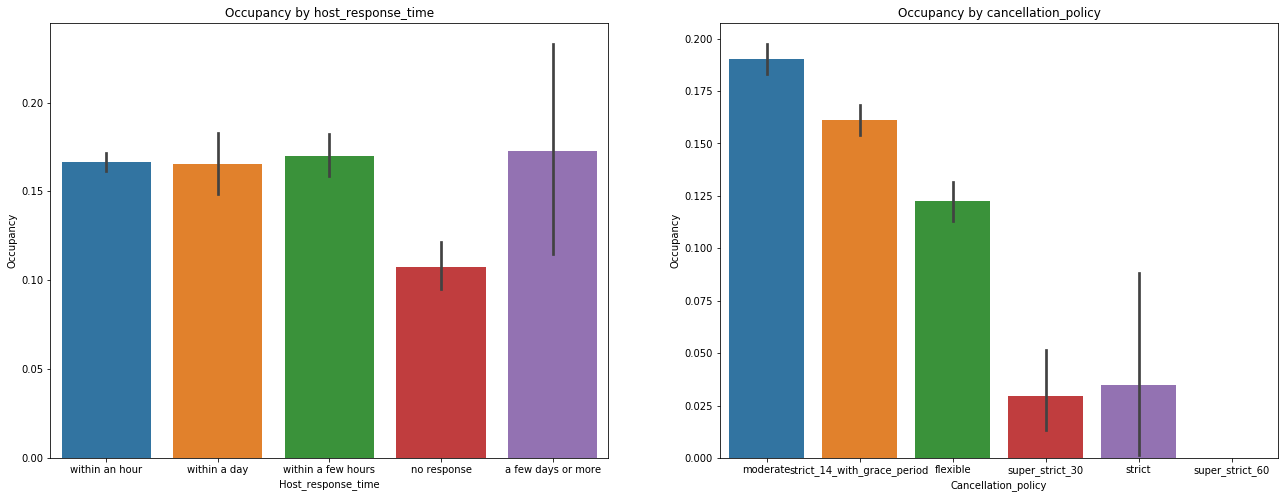

In [14]:
# Occupancy plot by room_type
count, ax = plt.subplots(1,2, figsize = (22,8))
ax = sns.barplot(x="host_response_time", y="occupancy_rate_month",data=listings_occupancy, ax=ax[0])
ax.set_title('Occupancy by host_response_time')
ax.set_xlabel('Host_response_time')
ax.set_ylabel('Occupancy')

ax = sns.barplot(x="cancellation_policy", y="occupancy_rate_month",data=listings_occupancy)
ax.set_title('Occupancy by cancellation_policy')
ax.set_xlabel('Cancellation_policy')
ax.set_ylabel('Occupancy')

#### As expected, if the host doesnt respond to requests from guest, the occupancy is low. Similarly with cancellation policy, moderate to flexible cancellation policy has better occupancy compared to strict 30 day policy or higher.

## Feature Extraction

#### Since neighborhood doesnt have a good sensitivity to occupancy rate, we can try to extract distance to SF senter and see if that has an impact on occupancy.

In [15]:
# For extracting distance from Sanfranciso center to each latitude/longitude 
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# For extracting distance to San Francisco city center
geolocator = Nominatim(timeout=3)
location = geolocator.geocode('San Francisco')
SF_lat_long = str(location.latitude) + ',' + str(location.longitude)

listings_occupancy['lat_long'] = listings_occupancy['latitude'].astype(str) + ',' + \
listings_occupancy['longitude'].astype(str)

In [16]:
distance = []
for location in range (listings_occupancy.shape[0]):
    distance.append(round(geodesic(listings_occupancy['lat_long'][location], SF_lat_long).miles,2))

listings_occupancy ['distance_to_SFcenter'] = distance

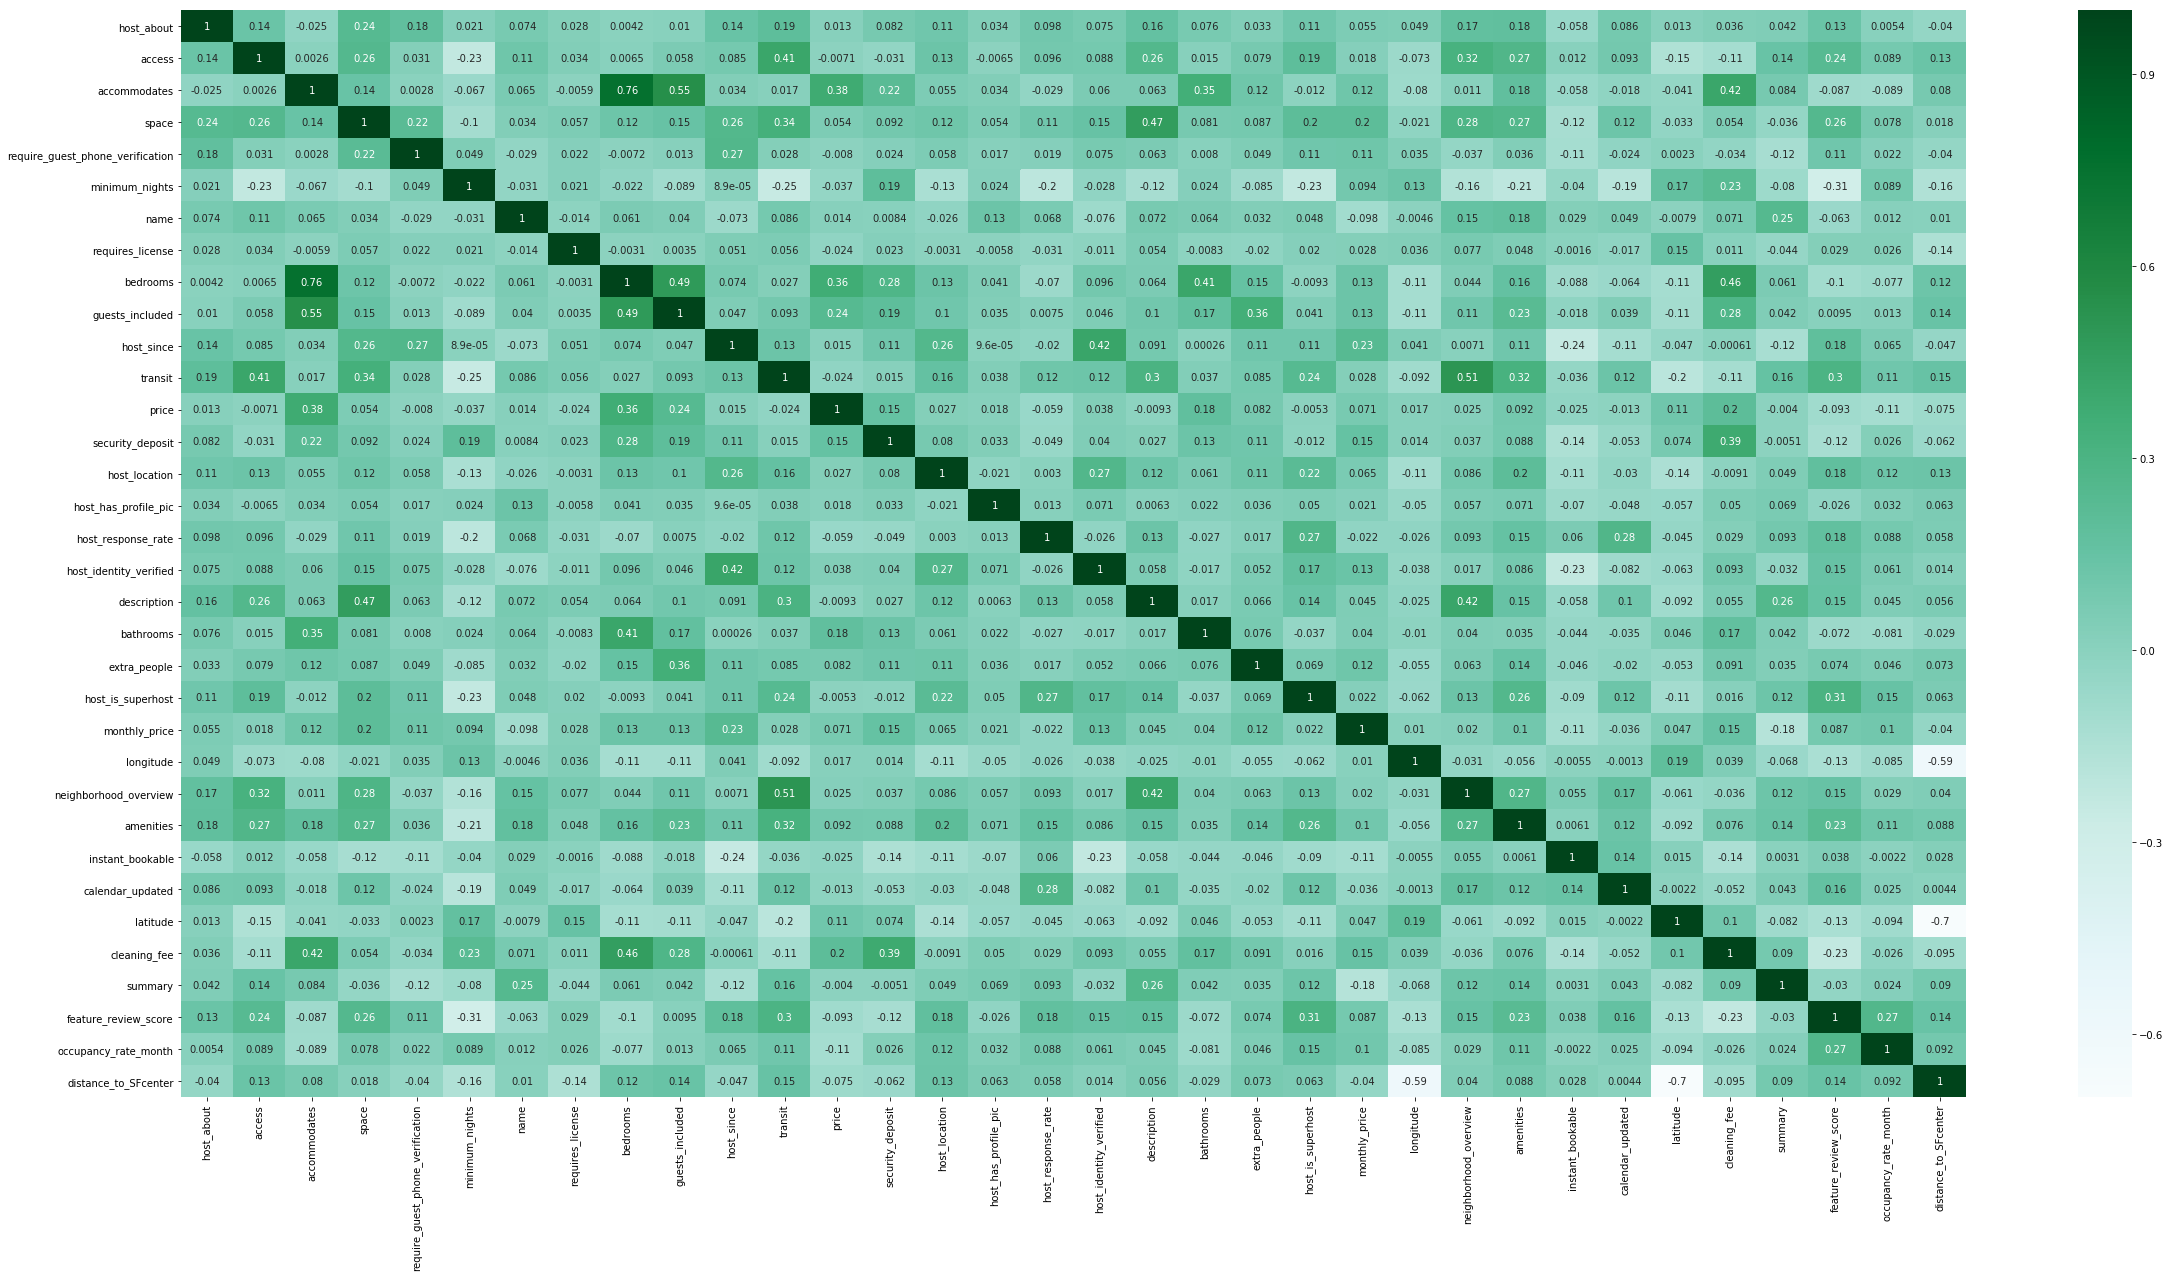

In [17]:
# Heatmap to check for correlations
plt.rcParams["figure.figsize"] = "40,20"
sns.heatmap(listings_occupancy.corr(), annot=True, cmap='BuGn')

#### From the corrplot, we need to remove latitude, longitude since they are used for calculating distance to SF center.

In [18]:
listings_occupancy = listings_occupancy.drop(['property_type', 'latitude', 'longitude','lat_long',
                                              'host_name'], axis=1)

In [19]:
listings_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 37 columns):
host_about                          6682 non-null float64
access                              6682 non-null float64
accommodates                        6682 non-null int64
space                               6682 non-null float64
require_guest_phone_verification    6682 non-null int64
minimum_nights                      6682 non-null int64
name                                6682 non-null int64
room_type                           6682 non-null object
requires_license                    6682 non-null int64
host_response_time                  6682 non-null object
bedrooms                            6682 non-null float64
guests_included                     6682 non-null int64
host_since                          6682 non-null int64
bed_type                            6682 non-null object
transit                             6682 non-null float64
price                               6682

## Predictor Scaling

In [26]:
listings_continous = listings_occupancy.select_dtypes(exclude='object')
# Scaling the continous data
scaler = RobustScaler()
listings_continous_scaled = pd.DataFrame(scaler.fit_transform(listings_continous),
                                         columns = listings_continous.columns.tolist())
# Creating dummies for the objects
listings_objects = pd.get_dummies(listings_occupancy.select_dtypes(include='object'))
pred_occupancy, resp_occupancy = pd.concat([listings_continous_scaled,listings_objects],axis=1).drop(['occupancy_rate_month'], 
                                                    axis=1), listings_continous['occupancy_rate_month']

## Linear Regression

In [32]:
#splitting the data into train and test splits
pred_train, pred_test, resp_train, resp_test = train_test_split(pred_occupancy, resp_occupancy, random_state=42)

In [33]:
model = sm.OLS(resp_occupancy, pred_occupancy)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     occupancy_rate_month   R-squared:                       0.183
Model:                              OLS   Adj. R-squared:                  0.173
Method:                   Least Squares   F-statistic:                     18.29
Date:                  Sun, 07 Apr 2019   Prob (F-statistic):          5.44e-228
Time:                          19:21:56   Log-Likelihood:                 2350.3
No. Observations:                  6682   AIC:                            -4537.
Df Residuals:                      6600   BIC:                            -3978.
Df Model:                            81                                         
Covariance Type:              nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
host_about                                         -0.0139      0.003     -5.418      0.000      -0.019      -0.009
access                                              0.0057      0.002      2.271      0.023       0.001       0.011
accommodates                                       -0.0113      0.004     -2.888      0.004      -0.019      -0.004
space                                               0.0053      0.006      0.929      0.353      -0.006       0.016
require_guest_phone_verification                   -0.0155      0.010     -1.593      0.111      -0.035       0.004
minimum_nights                                      0.0606      0.004     16.588      0.000       0.053       0.068
name                                                0.0065      0.003      1.951      0.051   -3.18e-05       0.013
requires_license                                    0.0385      0.027      1.431      0.153      -0.014       0.091
bedrooms                                           -0.0127      0.004     -3.198      0.001      -0.021      -0.005
guests_included                                     0.0049      0.002      2.332      0.020       0.001       0.009
host_since                                         -0.0088      0.004     -2.251      0.024      -0.017      -0.001
transit                                             0.0061      0.003      1.753      0.080      -0.001       0.013
price                                              -0.0045      0.001     -4.279      0.000      -0.007      -0.002
security_deposit                                    0.0033      0.002      1.905      0.057    -9.6e-05       0.007
host_location                                       0.0299      0.007      4.363      0.000       0.016       0.043
host_has_profile_pic                                0.0239      0.034      0.713      0.476      -0.042       0.090
host_response_rate                                  0.0056      0.002      3.325      0.001       0.002       0.009
host_identity_verified                             -0.0008      0.005     -0.165      0.869      -0.011       0.009
description                                        -0.0013      0.001     -1.620      0.105      -0.003       0.000
bathrooms                                          -0.0026      0.002     -1.720      0.086      -0.006       0.000
extra_people                                        0.0019      0.002      0.985      0.325      -0.002       0.006
host_is_superhost                                   0.0249      0.005      4.856      0.000       0.015       0.035
monthly_price                                    6.503e-06    1.2e-06      5.420      0.000    4.15e-06    8.85e-06
neighborhood_overview                        

In [34]:
type(results.pvalues)
#results.tvalues
#print('Parameters: ', results.params)
ols_results = pd.concat([results.params,results.pvalues,results.tvalues], axis=1)
ols_results.columns = ['Coefs','pvalues','tvalues']
ols_results.abs()[ols_results.pvalues < 1e-03].sort_values(by='pvalues', ascending=True)

,Coefs,pvalues,tvalues
feature_review_score,0.028251,1.614564e-73,18.366494
minimum_nights,0.060562,1.419305e-60,16.587814
cancellation_policy_moderate,0.074528,9.239679e-11,6.489457
cancellation_policy_strict_14_with_grace_period,0.068645,1.361622e-09,6.068622
monthly_price,0.000007,6.162580e-08,5.420241
host_about,0.013899,6.256924e-08,5.417512
room_type_Entire home/apt,0.054075,3.021118e-07,5.127414
host_is_superhost,0.024872,1.222902e-06,4.856404
host_location,0.029873,1.304317e-05,4.362685
price,0.004494,1.901065e-05,4.279331


#### The R2 score of the linear model is only 18.3%. Looking at the coefficients which have very low p-value, feature_review_score, minimum nights, flexible cancellation policy, if the room_type is an entire home/apt, host is super host are the top contibutors to have a better occupancy.

## Random Forests 

In [35]:
#Using Random forest regressor
rforest = RandomForestRegressor(random_state=42, n_jobs=-1)

#Performing a randomized search for finding best parameters
param_dist = {'n_estimators': range(500,1500,500),
              'max_depth': range(1,8,2),
              'max_features': range(1,20,2),
              'min_samples_split': range(500,2000,500)
             }
rforest_cv = RandomizedSearchCV(rforest, param_distributions=param_dist, cv=10, scoring='explained_variance')

In [36]:
rforest_cv.fit(pred_train, resp_train)
rforest_cv

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': range(500, 1500, 500), 'max_depth': range(1, 8, 2), 'max_features': range(1, 20, 2), 'min_samples_split': range(500, 2000, 500)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='explained_variance',
          verbose=0)

In [37]:
resp_pred = rforest_cv.predict(pred_test)
print(rforest_cv.score(pred_test, resp_test))
best_pred_new = rforest_cv.best_estimator_
best_pred_new

0.2318698284412153


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Text(0, 0.5, 'Feature Importance')

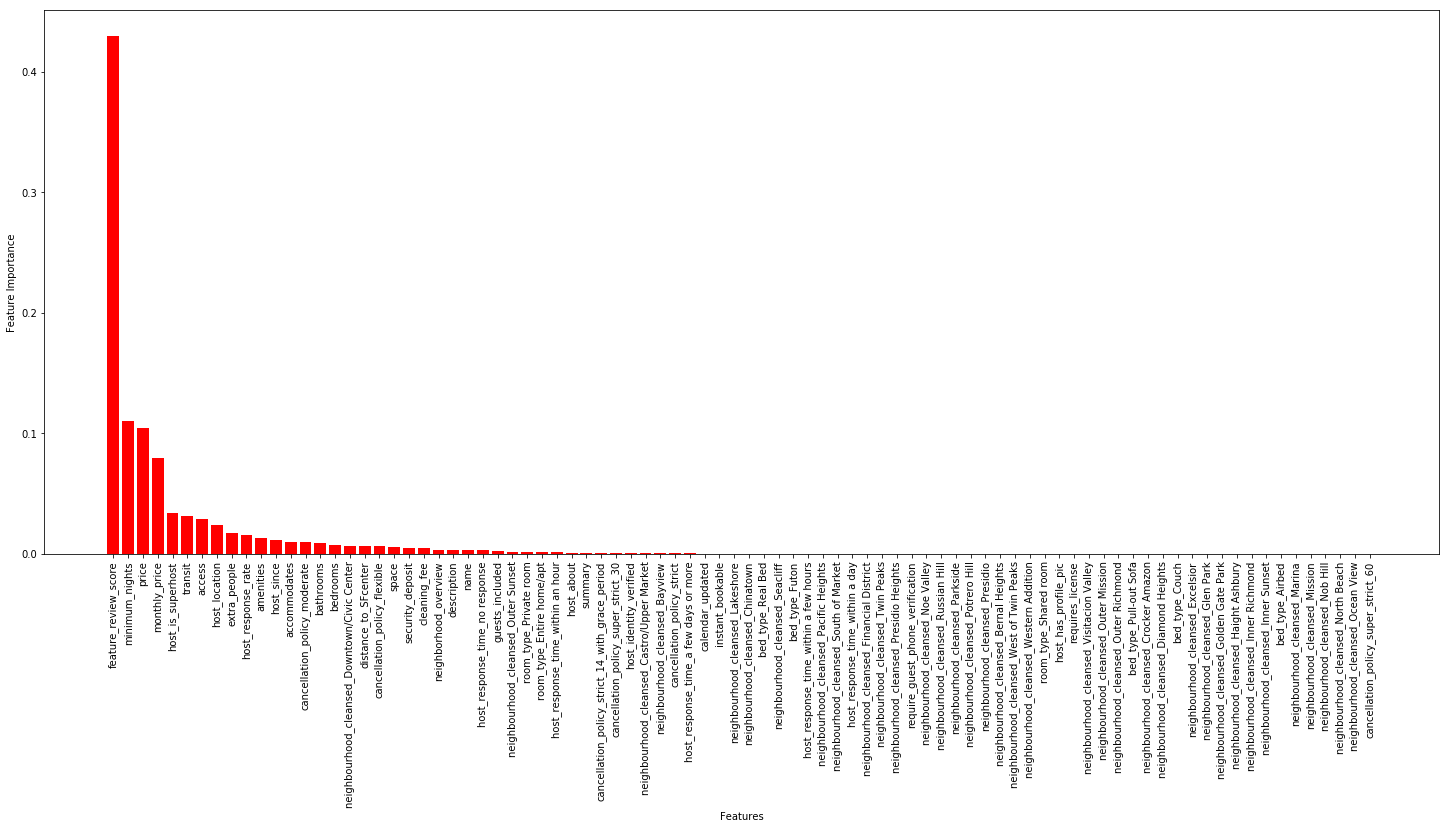

In [38]:
feature_importances = pd.DataFrame(best_pred_new.feature_importances_ ,
                                   index = pred_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.rcParams["figure.figsize"] = "25,10"
plt.bar(feature_importances.index, feature_importances.importance, color = "red")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")

#### The Random Forest algorithm has an R2 of 23%. Similar to OLS, feature_review_score and minimum_nights are the top predictors of high accuracy. Price, host_is_superhost, more ways to transit, access, if the host lives in california or not, extra people, host_response_rate and more amenities seem to impact occupancy.

## XGBoosting Algorithm

In [39]:
# Using XG boosting
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
param_dist = {'n_estimators': [1000,1500,2000],
              'learning_rate': [0.01,0.001],
              'max_depth': [2,3,4]
             }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=10)

In [40]:
xgb_cv.fit(pred_train, resp_train)
res_pred = xgb_cv.predict(pred_test)

In [41]:
print(f'Variance score for Gradient boost Algorithm is: {xgb_cv.score(pred_test, resp_test)}')
print(f'MSE : {mean_squared_error(resp_test,res_pred)}')
rough_errors = np.round(np.sqrt(mean_squared_error(resp_test,res_pred)),2)
print(f'Model makes rough miscalculations of about {rough_errors}')

Variance score for Gradient boost Algorithm is: 0.6669245357909888
MSE : 0.011252386710668062
Model makes rough miscalculations of about 0.11


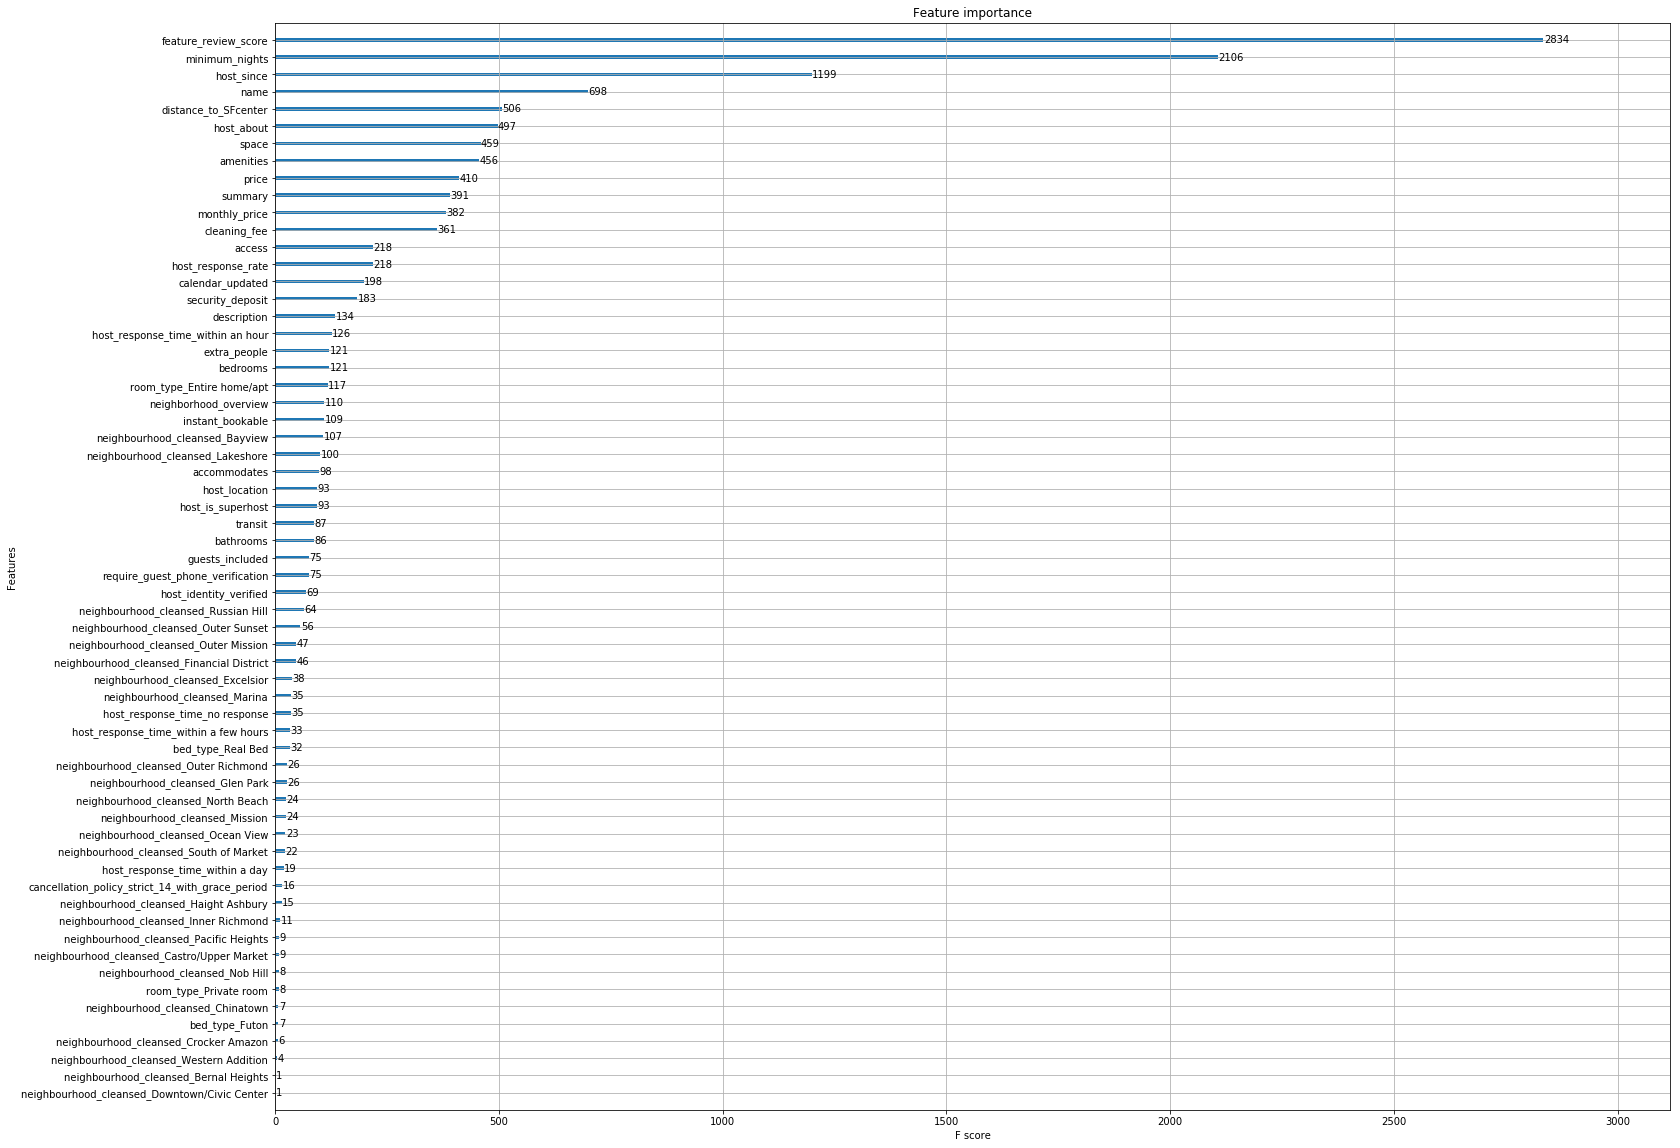

In [42]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = "25,20"
plot_importance(xgb_cv.best_estimator_)

### XG Boost Algorithm has an R2 of 67% which is the best fit so far. This model can be used for finding out which factors influence the occupancy

In [45]:
import shap
%time shap_values = shap.TreeExplainer(xgb_cv.best_estimator_).shap_values(pred_test)

Wall time: 3.09 s


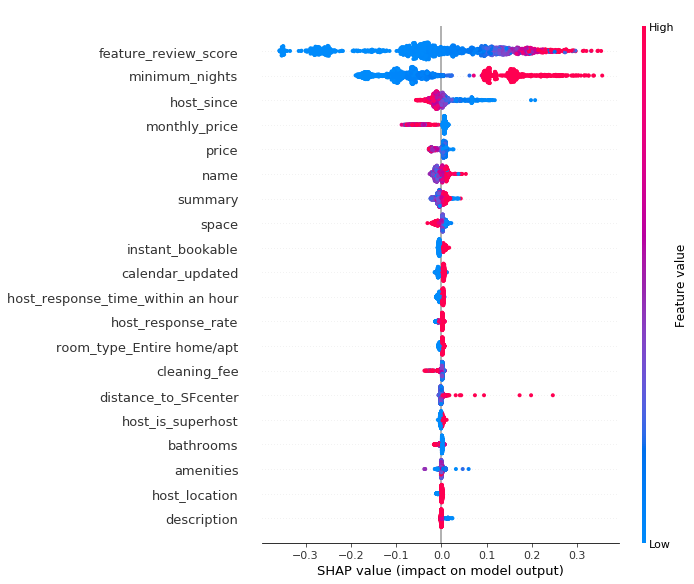

In [46]:
shap.summary_plot(shap_values, pred_test)

### Hosts who have the listings with the following factors tend to better occupancy:
### 1) Feature_review_score - if the listings have more number of reviews and high review ratings which intutively makes sense
### 2) Minimum number of nights are large- This is something which I didnt think of, it looks like long term stays tend to have better occupancy
### 3) New hosts seem to do better with occupancy rates
### 4) Low monthly and daily prices - there is no surprise here!
### 5) Providing more details in the listing name and summary seems to help occupancy as well

### Other things like instant booking capability, updaing the calender frequently, host response time and host response rate, also entire home/apt seem to have high occupancy.